In [1]:
import sys
import gpflow
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from fffit.utils import (
    shuffle_and_split,
    values_real_to_scaled,
    values_scaled_to_real,
    variances_scaled_to_real,
)

from fffit.plot import (
    plot_model_performance,
    plot_slices_temperature,
    plot_slices_params,
    plot_model_vs_test,
)

from fffit.models import run_gpflow_scipy

sys.path.append("../")

from utils.r143a import R143aConstants
from utils.id_new_samples import prepare_df_density



2022-07-14 12:17:05.617285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/crc/usr/local/lib
2022-07-14 12:17:05.617320: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
R143a = R143aConstants()

pdf = PdfPages('fig_gp_examples.pdf')

############################# QUANTITIES TO EDIT #############################
##############################################################################

iternum = 1
gp_shuffle_seed = 8278573

##############################################################################
##############################################################################

csv_path = "../csv/"
in_csv_names = ["r143a-density-iter" + str(i) + "-results.csv" for i in range(1, iternum+1)]
out_csv_name = "r143a-density-iter" + str(iternum + 1) + "-params.csv"

In [3]:
df_csvs = [pd.read_csv(csv_path + in_csv_name, index_col=0) for in_csv_name in in_csv_names]
df_csv = pd.concat(df_csvs)
df_all, df_liq, df_vap = prepare_df_density(df_csv, R143a,liquid_density_threshold=500) #I don't think we want a list here
df_all = df_liq # Adding this line will show Liquid density only in the graphs: Is this what we want?

2022-07-14 12:17:10.247827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/crc/usr/local/lib
2022-07-14 12:17:10.247869: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-14 12:17:10.247892: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (maginnfe.crc.nd.edu): /proc/driver/nvidia/version does not exist
2022-07-14 12:17:10.248220: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(9, 1)",float64,[[0....
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(9,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(9, 1)",float64,[[0.57663966...
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[-2.36033364]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.8396429762246738
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(9,)",float64,"[1.18697166, 1.32486229, 0.70930623..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0006348771151485686


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(9, 1)",float64,[[0....
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(9,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(9, 1)",float64,[[0.15242119...
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[-6.66477749]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,75.97027431380509
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(9,)",float64,"[11.95700194, 12.52712998, 7.26211163..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00014813060475920217


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(9, 1)",float64,[[0....
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(9,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(9, 1)",float64,[[0.0660249...
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[-5.30640107]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,19.70669897500609
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(9,)",float64,"[3.65828569, 4.07825206, 2.19308305..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00039312756025353747


Model: RBF. Mean squared err: 3.04e+01
Model: Matern32. Mean squared err: 1.74e+00
Model: Matern52. Mean squared err: 1.33e+01
Model: RBF. Mean squared err: 1.54e+03
Model: Matern32. Mean squared err: 1.71e+03
Model: Matern52. Mean squared err: 1.59e+03


TypeError: 'NoneType' object is not iterable

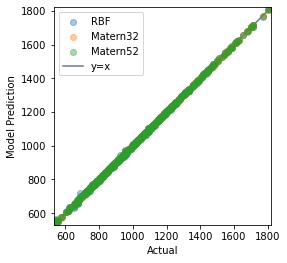

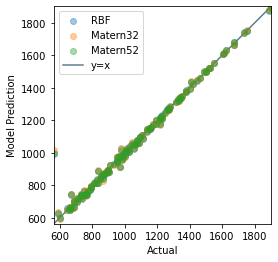

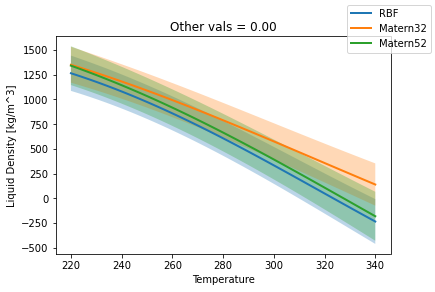

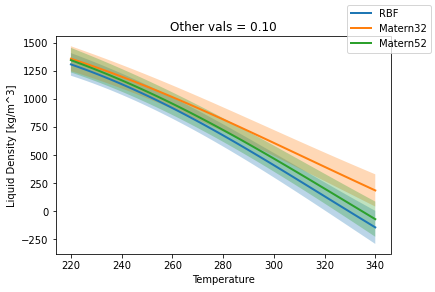

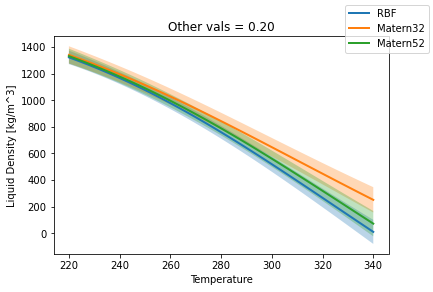

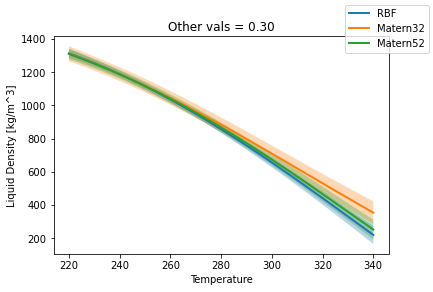

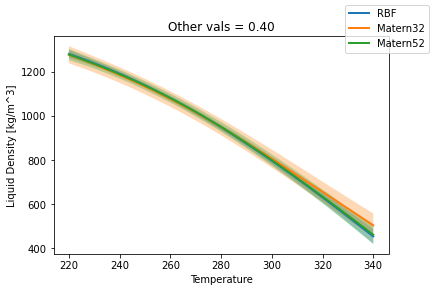

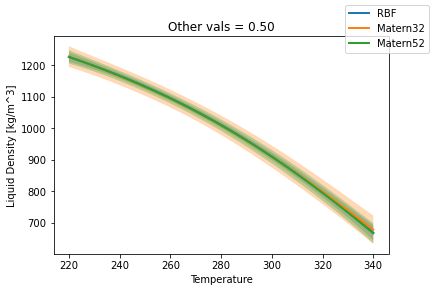

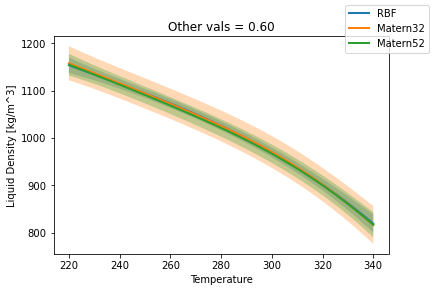

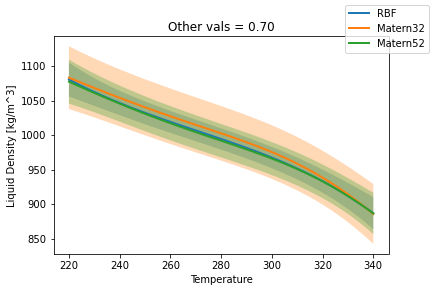

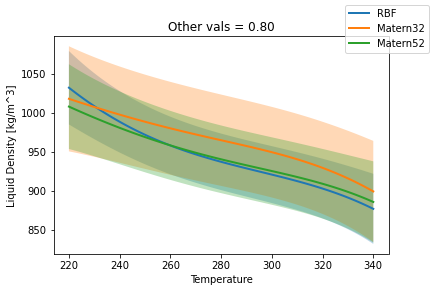

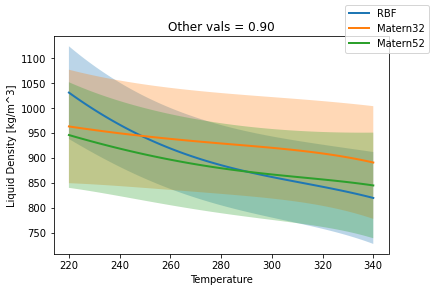

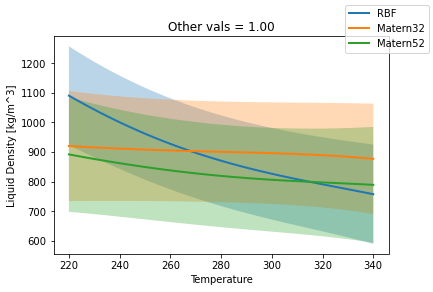

In [4]:
### Fit GP Model to liquid density
param_names = list(R143a.param_names) + ["temperature"]
property_name = "md_density"
x_train, y_train, x_test, y_test = shuffle_and_split(
    df_all, param_names, property_name, shuffle_seed=gp_shuffle_seed, fraction_train=0.8
)

# Fit model
models = {}
models["RBF"] = run_gpflow_scipy(
    x_train,
    y_train,
    gpflow.kernels.RBF(lengthscales=np.ones(R143a.n_params + 1)),
)
models["Matern32"] = run_gpflow_scipy(
    x_train,
    y_train,
    gpflow.kernels.Matern32(lengthscales=np.ones(R143a.n_params + 1)),
)

models["Matern52"] = run_gpflow_scipy(
    x_train,
    y_train,
    gpflow.kernels.Matern52(lengthscales=np.ones(R143a.n_params + 1)),
)

# Plot model performance on train and test points
pdf.savefig(plot_model_performance(models, x_train, y_train, R143a.liq_density_bounds))
pdf.savefig(plot_model_performance(models, x_test, y_test, R143a.liq_density_bounds))

# Plot temperature slices
figs = plot_slices_temperature(
    models,
    R143a.n_params,
    R143a.temperature_bounds,
    R143a.liq_density_bounds,
    property_name="Liquid Density [kg/m^3]",
)

for fig in figs:
    pdf.savefig(fig)
del figs

# Plot parameter slices
for param_name in R143a.param_names:
    figs = plot_slices_params(
        models,
        param_name,
        R143a.param_names,
        300,
        R143a.temperature_bounds,
        R143a.liq_density_bounds,
        property_name="Liquid Density [kg/m^3]",
    )
    for fig in figs:
        pdf.savefig(fig)
    del figs

# Loop over test params
for test_params in x_test[:,:R143a.n_params]:
    train_points = []
    test_points = []
    # Locate rows where parameter set == test parameter set
    matches = np.unique(np.where((df_all[list(R143a.param_names)] == test_params).all(axis=1))[0])
    # Loop over all matches -- these will be different temperatures
    for match in matches:
        # If the match (including T) is in the test set, then append to test points
        if np.where((df_all.values[match,:R143a.n_params+1] == x_test[:,:R143a.n_params+1]).all(axis=1))[0].shape[0] == 1:
            test_points.append([df_all["temperature"].iloc[match],df_all[property_name].iloc[match]])
        # Else append to train points
        else:
            train_points.append([df_all["temperature"].iloc[match],df_all[property_name].iloc[match]])

    pdf.savefig(
        plot_model_vs_test(
            models,
            test_params,
            np.asarray(train_points),
            np.asarray(test_points),
            R143a.temperature_bounds,
            R143a.liq_density_bounds,
            property_name="Liquid Density [kg/m^3]"
        )
    )

pdf.close()

